# Import Dependencies

In [1]:
import sys
sys.path.append(r'C:\Users\tomer\Desktop\Fingers-Gesture-Recognition')

import numpy as np
import torch
import Source.models as models

from Source.pipelines import Data_Pipeline
from Source.data_manager import Data_Manager
from warnings import simplefilter
from pathlib import Path
from importlib import reload

# ignore some warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# Construct a Data Manager

In [2]:
# pipeline definition and data manager creation
data_path = Path(r'I:\My Drive\finger gesture recognition')
pipeline = Data_Pipeline(base_data_files_path=data_path)  # configure the data pipeline you would like to use (check pipelines module for more info)
subject = 18
dm = Data_Manager([subject], pipeline)
print(dm.data_info())

Available experiments in the data manager: ['018_1_4', '018_1_2', '018_2_4', '018_2_3', '018_1_3', '018_2_2', '018_2_1', '018_1_1']
Experiments format is: subject_session_position
None


# task 1 - single subject, 80/20 train/test split from all sessions

## data extraction

In [6]:
# extract datasets from the data manager - labels format: "<subject>_<session>_<position>_<gesture>_<iteration_number>"
dataset = dm.get_dataset(experiments=[f'{subject:03d}_*_*'])

data = dataset[0]
labels = dataset[1]

# train test split
data_train, data_test, labels_train, labels_test = models.pre_training_utils\
    .train_test_split_by_gesture(data, labels=labels, test_size=0.2)

# reshape the data to match the model architecture
data_train = data_train.reshape(data_train.shape[0], 1, 4, 4)  # reshape to fit the CNN input
data_test = data_test.reshape(data_test.shape[0], 1, 4, 4)  # reshape to fit the CNN input

Experiments in datasets: ['018_1_4', '018_1_2', '018_2_4', '018_2_3', '018_1_3', '018_2_2', '018_2_1', '018_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/8 [00:00<?, ?exp/s]

finished extracting the dataset
number of gestures with only one repetition: 0
Their names are: []


## model training

training model: 100%|██████████| 200/200 [17:18<00:00,  5.19s/epoch]


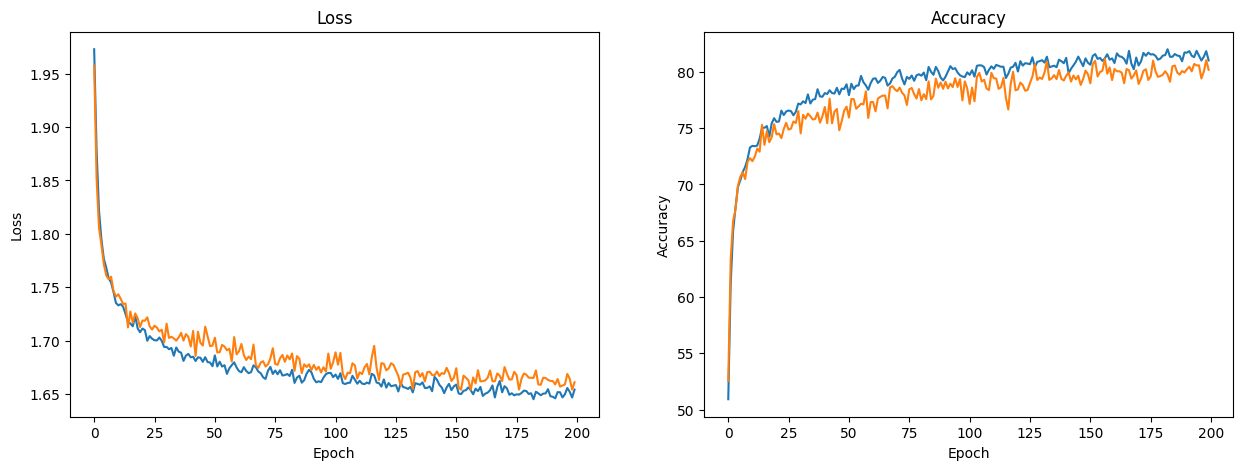

Done Training!


In [7]:
# set and train a model (cv or not)
model = models.Net(num_classes=10, dropout_rate=0.1)
model.fit_model(data_train, labels_train, val_data=data_test, val_labels=labels_test, num_epochs=200, batch_size=64,
                lr=0.001, l2_weight=0.0001)

## model evaluation

0.93125

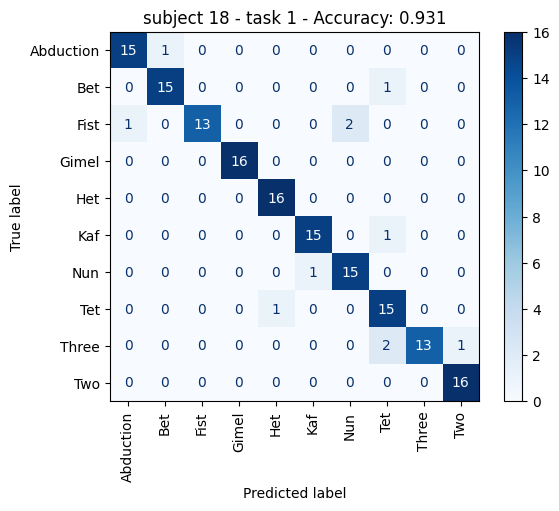

In [9]:
model.evaluate_model(model.val_data, model.val_labels, cm_title=f'subject {subject} - task 1')

# task 2 - using 70% of session 2 as testing data (the rest is used for training)

## data extraction

In [10]:
# extract datasets from the data manager - labels format: "<subject>_<session>_<position>_<gesture>_<iteration_number>"
dataset_1 = dm.get_dataset(experiments=[f'{subject:03d}_1_*'])
dataset_2 = dm.get_dataset(experiments=[f'{subject:03d}_2_*'])

data_1 = dataset_2[0]
labels_1 = dataset_2[1]

data_2 = dataset_1[0]
labels_2 = dataset_1[1]

# train test split
data_2_train, data_2_test, labels_2_train, labels_2_test = models.pre_training_utils\
    .train_test_split_by_gesture(data_2, labels=labels_2, test_size=0.7)

# reshape the data to match the model architecture input
data_1 = data_1.reshape(data_1.shape[0], 1, 4, 4)
data_2_train = data_2_train.reshape(data_2_train.shape[0], 1, 4, 4)
data_2_test = data_2_test.reshape(data_2_test.shape[0], 1, 4, 4)

Experiments in datasets: ['018_1_4', '018_1_2', '018_1_3', '018_1_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/4 [00:00<?, ?exp/s]

finished extracting the dataset
Experiments in datasets: ['018_2_4', '018_2_3', '018_2_2', '018_2_1']
Starting to extract datasets


Loading experiments datasets:   0%|          | 0/4 [00:00<?, ?exp/s]

finished extracting the dataset
number of gestures with only one repetition: 0
Their names are: []


## model training

training model: 100%|██████████| 200/200 [11:08<00:00,  3.34s/epoch]


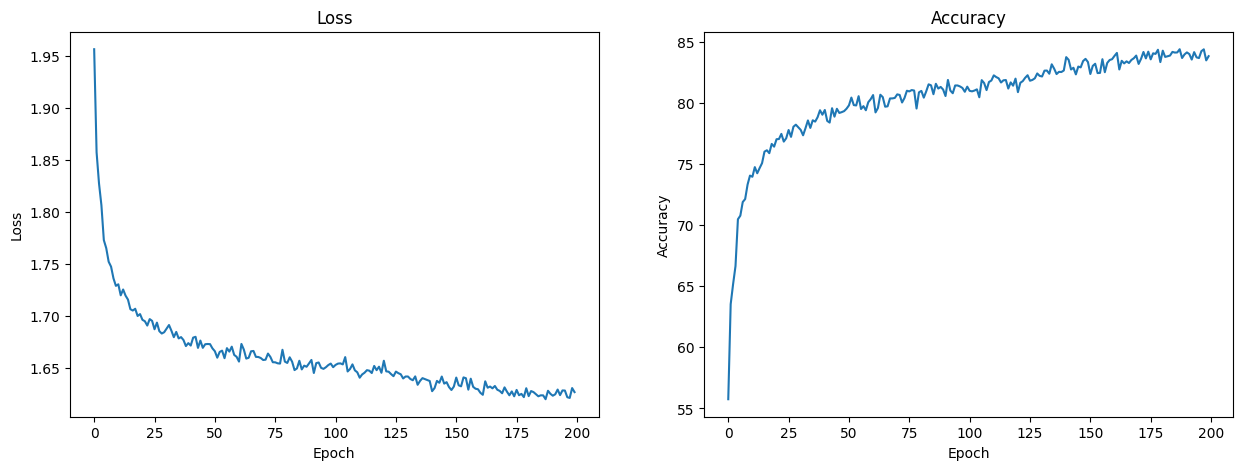

Done Training!


training model: 100%|██████████| 40/40 [01:09<00:00,  1.75s/epoch]


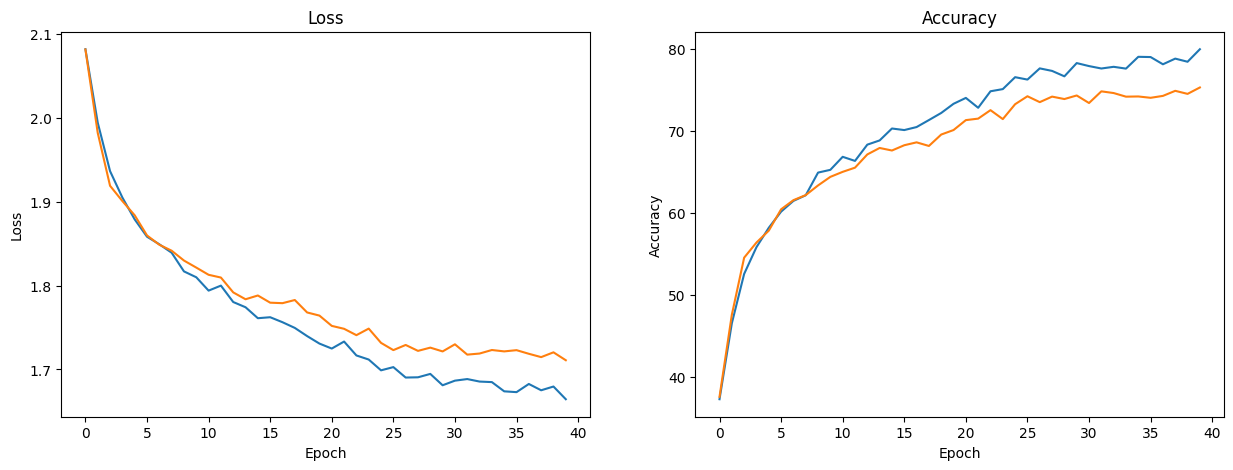

Done Training!


In [11]:
# set and train a model (cv or not)
model = models.Net(num_classes=10, dropout_rate=0.1)
# model = torch.compile(model)  # optimize for faster training
model.fit_model(data_1, labels_1, num_epochs=200, batch_size=64, lr=0.001, l2_weight=0.0001)
model.fit_model(data_2_train, labels_2_train, val_data=data_2_test, val_labels=labels_2_test, num_epochs=40,
                batch_size=64, lr=0.001, l2_weight=0.0001)

## model evaluation

0.8785714285714286

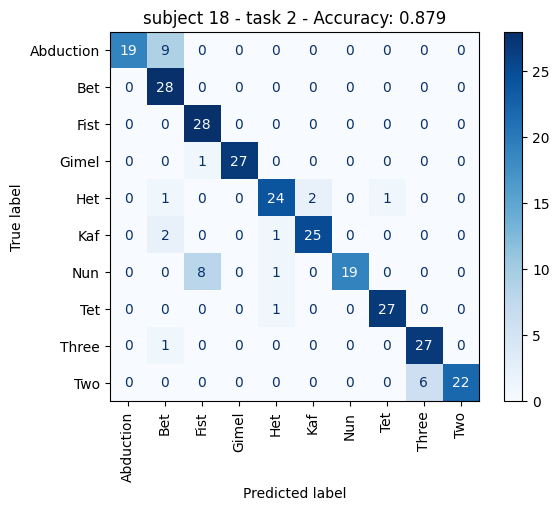

In [12]:
model.evaluate_model(data_2_test, labels_2_test, cm_title=f'subject {subject} - task 2')